In [330]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import math
import sys
from scipy import misc

In [373]:
# To simplify the plot of gray-scale image define a function
def plot_gray(img, figsize):
    plt.figure(figsize = figsize)
    plt.imshow(img, cmap = 'gray')
    plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000,)


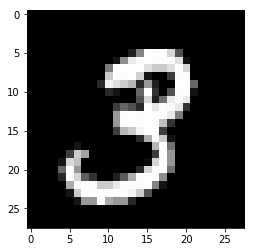

In [469]:
# Before solving the soduku puzzle, training a MNIST digit classification first using tensorflow
# Load data
mnist = input_data.read_data_sets("MNIST_data", one_hot = False)
plt.imshow(mnist.train.images[1].reshape([28,28]), cmap = 'gray')
print (mnist.train.labels.shape)

In [270]:
# Define model
def model(X, is_train):
    conv1 = tf.layers.conv2d(inputs = X, filters = 32, kernel_size = [5,5], padding = 'same', activation = tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = [2,2], strides = 2)
    conv2 = tf.layers.conv2d(inputs = pool1, filters = 64, kernel_size = [5,5], padding = 'same', activation = tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size = [2,2], strides = 2)
    pool2_flat = tf.contrib.layers.flatten(pool2)
    fc1 = tf.layers.dense(inputs = pool2_flat, units = 1024, activation = tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs = fc1, rate = 0.5, training = is_train)
#     fc2 = tf.layers.dense(inputs = dropout1, units = hidden_size, activation = tf.nn.relu)
#     dropout2 = tf.layers.dropout(inputs = fc2, rate = 0.5, training = is_train)
    return dropout1

In [272]:
# Training and evaluation
# Prepare data
X_train = mnist.train.images.reshape((-1, 28, 28, 1))
y_train = mnist.train.labels
X_test = mnist.test.images.reshape((-1, 28, 28, 1))
y_test = mnist.test.labels

# Hyperparameters
class_num = 10
learning_rate = 1e-4
num_epochs = 400
batch_size = 10
train_size = X_train.shape[0]
test_size = X_test.shape[0]

# Input
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.int32, [None])
is_train = tf.placeholder(tf.bool)

# Inference
features = model(X, is_train)
logits = tf.layers.dense(inputs = features, units = class_num)

# Loss function
onehot_labels = tf.one_hot(indices = tf.cast(y, tf.int32), depth = class_num)
loss = tf.losses.softmax_cross_entropy(onehot_labels = onehot_labels, logits = logits)

# Define training ops
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss = loss)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(onehot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define session
sess = tf.Session()

# Global intialization
sess.run(tf.global_variables_initializer())

# Training
new_training_loss = 0.0
for i in range(num_epochs):
    s = 0
    while s < train_size:
        e = min(s + batch_size, train_size)
        batch_X = X_train[s:e]
        batch_y = y_train[s:e]
        sess.run(train_op, feed_dict = {X: batch_X, y: batch_y, is_train: True})
        s = e
    [training_loss, training_score] = sess.run([loss, accuracy], feed_dict = {X: X_train, y: y_train, is_train: False})
    print ('num_epoch: %d, training loss: %f, traing accuracy: %f'%(i, training_loss, training_score))
    
    # Early stopping
    if math.fabs(training_loss - new_training_loss) < 1e-4:
        break
    new_training_loss = training_loss
    
# Testing
test_score = sess.run(accuracy, feed_dict = {X: X_test, y: y_test, is_train: False})
print ("testing accuracy: %f"%(test_score))

num_epoch: 0, training loss: 0.092201, traing accuracy: 0.969582
num_epoch: 1, training loss: 0.038820, traing accuracy: 0.987673
num_epoch: 2, training loss: 0.030399, traing accuracy: 0.990200
num_epoch: 3, training loss: 0.022998, traing accuracy: 0.992582
num_epoch: 4, training loss: 0.014643, traing accuracy: 0.995655
num_epoch: 5, training loss: 0.010560, traing accuracy: 0.996782
num_epoch: 6, training loss: 0.007781, traing accuracy: 0.997745
num_epoch: 7, training loss: 0.007412, traing accuracy: 0.997673
num_epoch: 8, training loss: 0.006565, traing accuracy: 0.998055
num_epoch: 9, training loss: 0.004854, traing accuracy: 0.998527
num_epoch: 10, training loss: 0.003561, traing accuracy: 0.999000
num_epoch: 11, training loss: 0.005207, traing accuracy: 0.998345
num_epoch: 12, training loss: 0.004140, traing accuracy: 0.998582
num_epoch: 13, training loss: 0.002745, traing accuracy: 0.999236
num_epoch: 14, training loss: 0.003177, traing accuracy: 0.999073
num_epoch: 15, train

(730, 807)


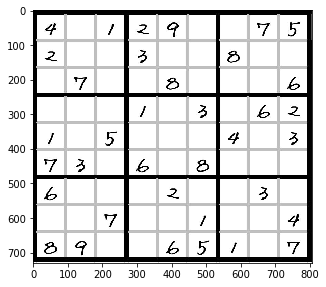

In [450]:
# Soduku puzzle solver
plt.figure(figsize = (5,5))
img = cv2.imread("manual3.bmp", 0)
plt.imshow(img, cmap = 'gray')
print (img.shape)

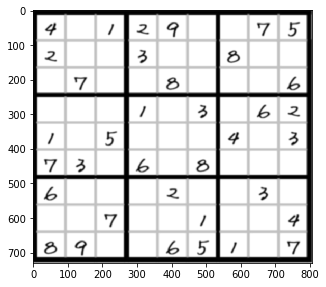

In [459]:
# Blue image to smooth out noise
plt.figure(figsize = (5,5))
g_img = cv2.GaussianBlur(src = img, ksize = (9,9), sigmaX = 0)
plt.imshow(g_img, cmap = 'gray')

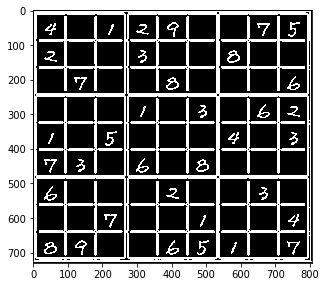

In [460]:
# Thresholding images
th_img = cv2.adaptiveThreshold(g_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
th_img = cv2.bitwise_not(th_img)
plt.figure(figsize = (5,5))
plt.imshow(th_img, cmap = 'gray')

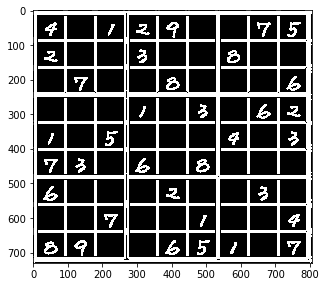

In [461]:
# Dilate image
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]])
dil_img = cv2.dilate(th_img, None)
plt.figure(figsize = (5,5))
plt.imshow(dil_img, cmap = 'gray')

In [462]:
# Contours finding
# Note: use dil_img.copy() instead of directy inputing dil_img, findContours will change the src image
_, contours, _ = cv2.findContours(dil_img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Sort according to contour area
sorted_contours = sorted(contours, key = lambda x: cv2.contourArea(x), reverse = True)

top left:  (12, 489) bottom right:  (262, 712)
top left:  (278, 489) bottom right:  (529, 711)
top left:  (541, 489) bottom right:  (791, 711)
top left:  (278, 252) bottom right:  (529, 474)
top left:  (12, 15) bottom right:  (263, 237)
top left:  (12, 252) bottom right:  (262, 474)
top left:  (541, 252) bottom right:  (791, 474)
top left:  (541, 15) bottom right:  (791, 237)
top left:  (278, 15) bottom right:  (528, 237)


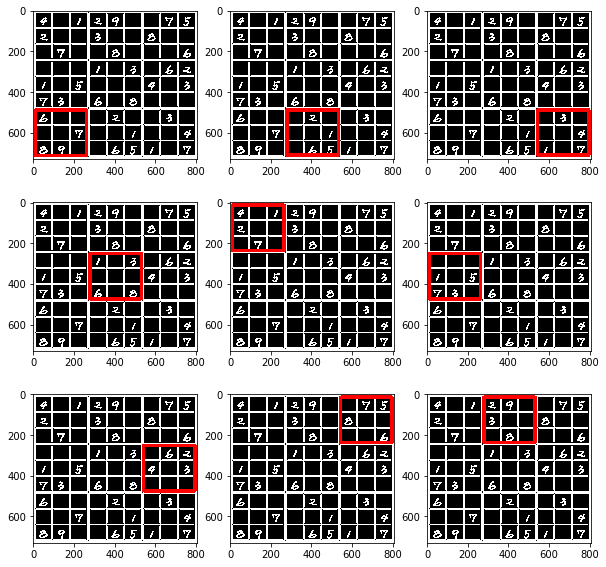

In [463]:
# Get the first 11 contours by the descending order of contour area.
# The biggest one is the outline
# The second to tenth is the outline for each 3*3 sub-soduku
blobs = []
plt.figure(figsize = (10,10))
for i in range(1, 10):
    # Approximate contour with lines
    perimeter = cv2.arcLength(sorted_contours[i], True)
    epsilon = 0.1 * cv2.arcLength(sorted_contours[i],True)
    approx = cv2.approxPolyDP(sorted_contours[i], epsilon, True)
    [tl_x, tl_y] = approx[0][0]
    [br_x, br_y] = approx[2][0]
    box_img = cv2.rectangle(cv2.cvtColor(dil_img, cv2.COLOR_GRAY2BGR), (tl_x, tl_y), (br_x, br_y), color = (255, 0, 0), thickness = 15)
    plt.subplot(3, 3, i)
    plt.imshow(box_img)
    # Store blobs in list
    blobs.append((tl_x, tl_y, br_x, br_y))
    print ('top left: ', (tl_x, tl_y), 'bottom right: ', (br_x, br_y))

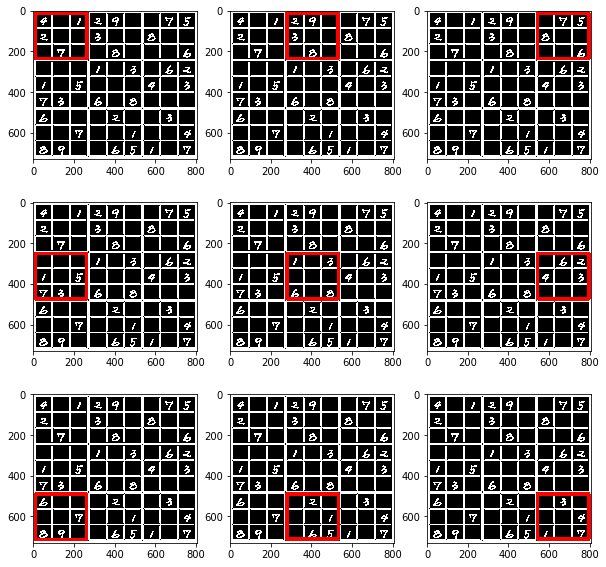

In [464]:
# Sort blobs by the location of blob in the image
# Calculate the center of each blob and sort the lsit in ascending order of center (x,y)
def blob_sorting(blobs):
    sorted_blobs = sorted(blobs, key = lambda x: x[1])
    sorted_blobs[:3] = sorted(sorted_blobs[:3], key = lambda x: x[0])
    sorted_blobs[3:6] = sorted(sorted_blobs[3:6], key = lambda x: x[0])
    sorted_blobs[6:9] = sorted(sorted_blobs[6:9], key = lambda x: x[0])
    return sorted_blobs
sorted_blobs = blob_sorting(blobs)
# Plot
plt.figure(figsize = (10,10))
i = 1
for (tl_x, tl_y, br_x, br_y) in sorted_blobs:
    sort_blob_img = cv2.rectangle(cv2.cvtColor(dil_img, cv2.COLOR_GRAY2BGR), (tl_x, tl_y), (br_x, br_y), color = (255, 0, 0), thickness = 15)
    plt.subplot(3, 3, i)
    plt.imshow(sort_blob_img)
    i += 1

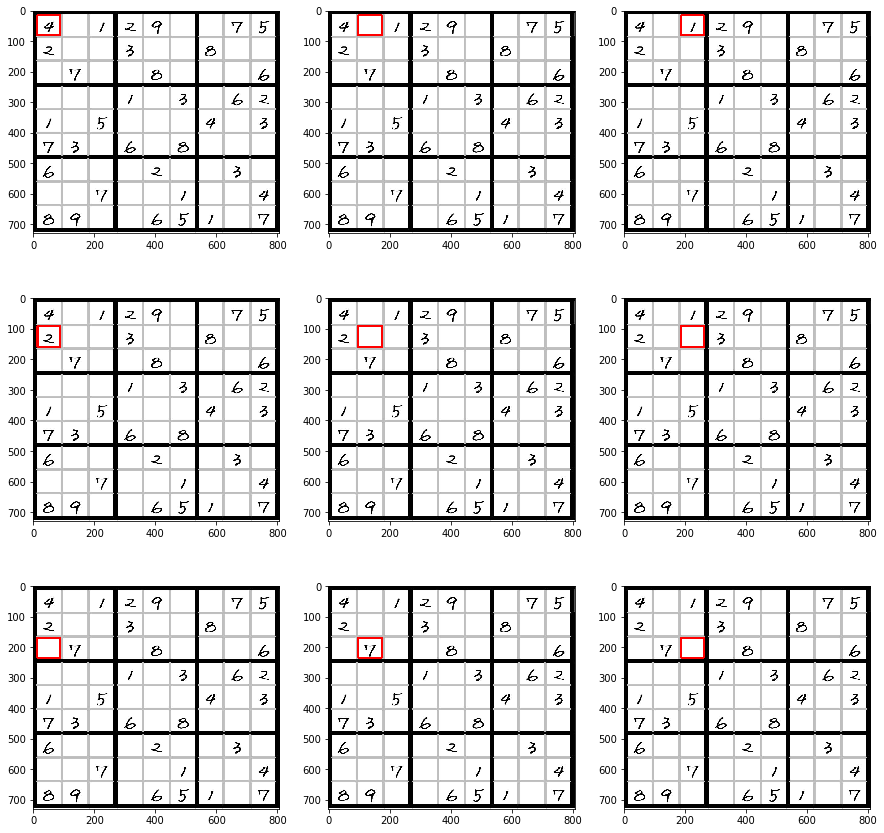

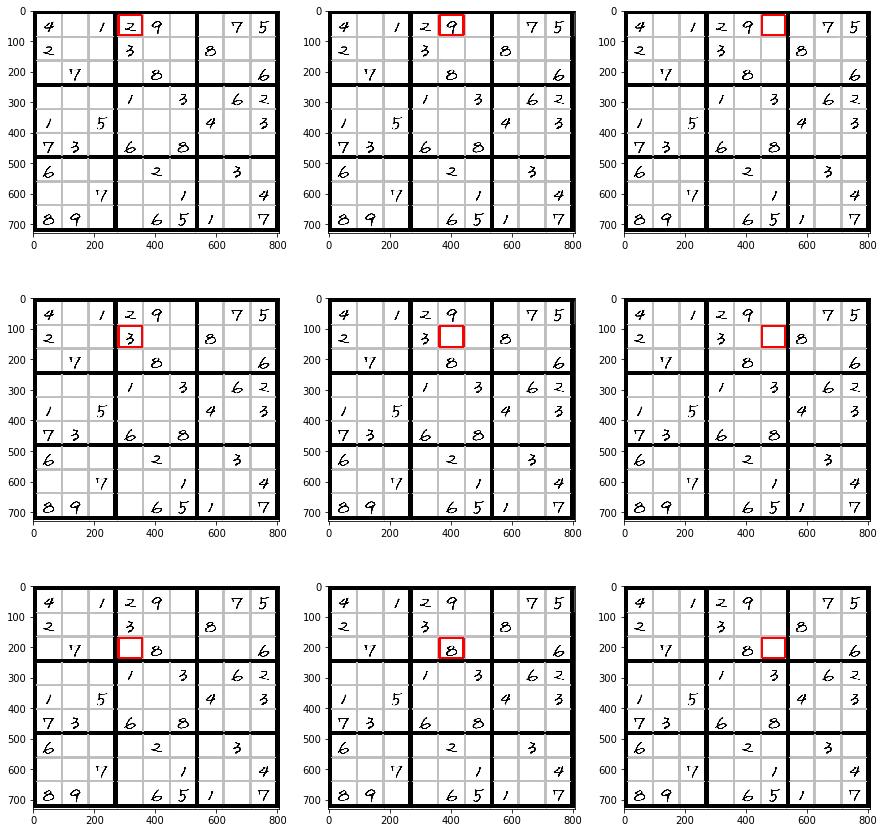

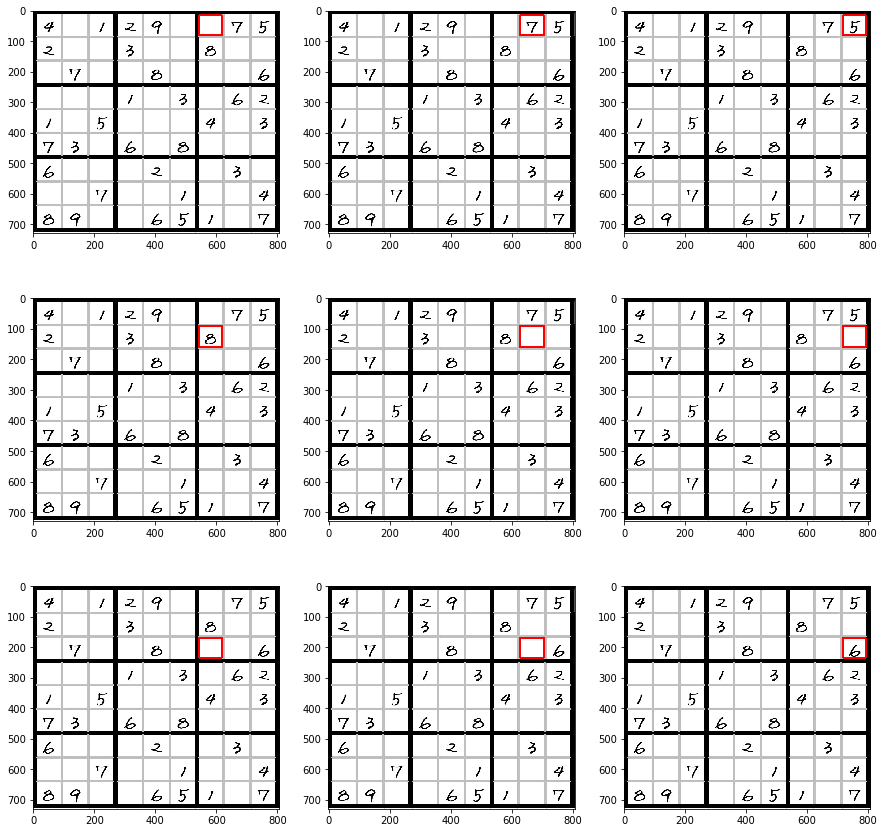

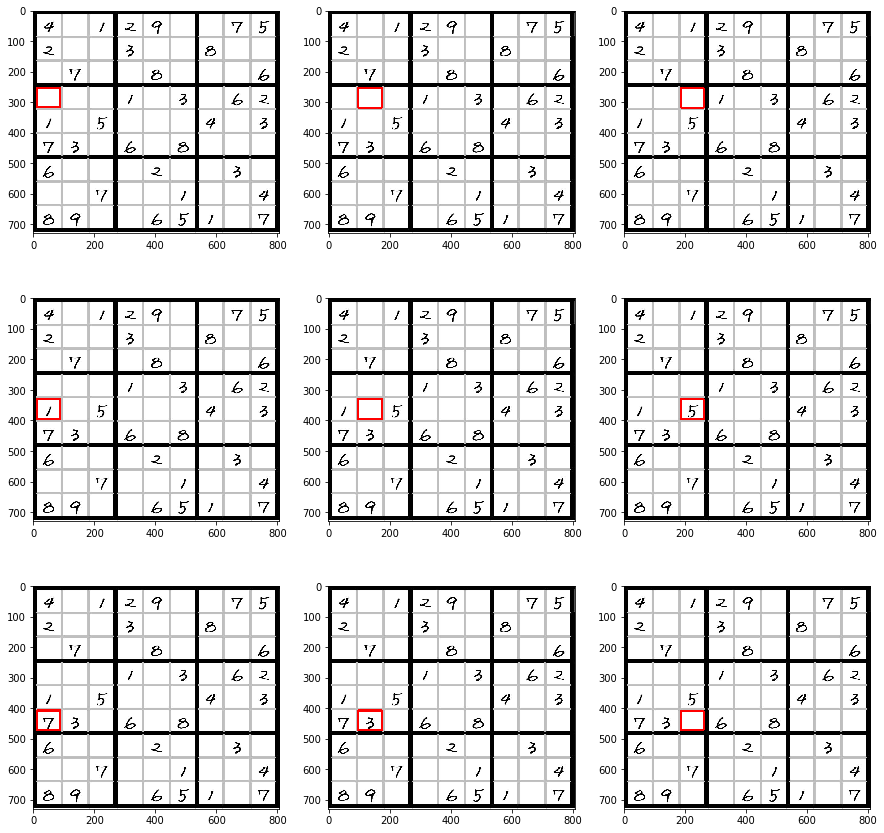

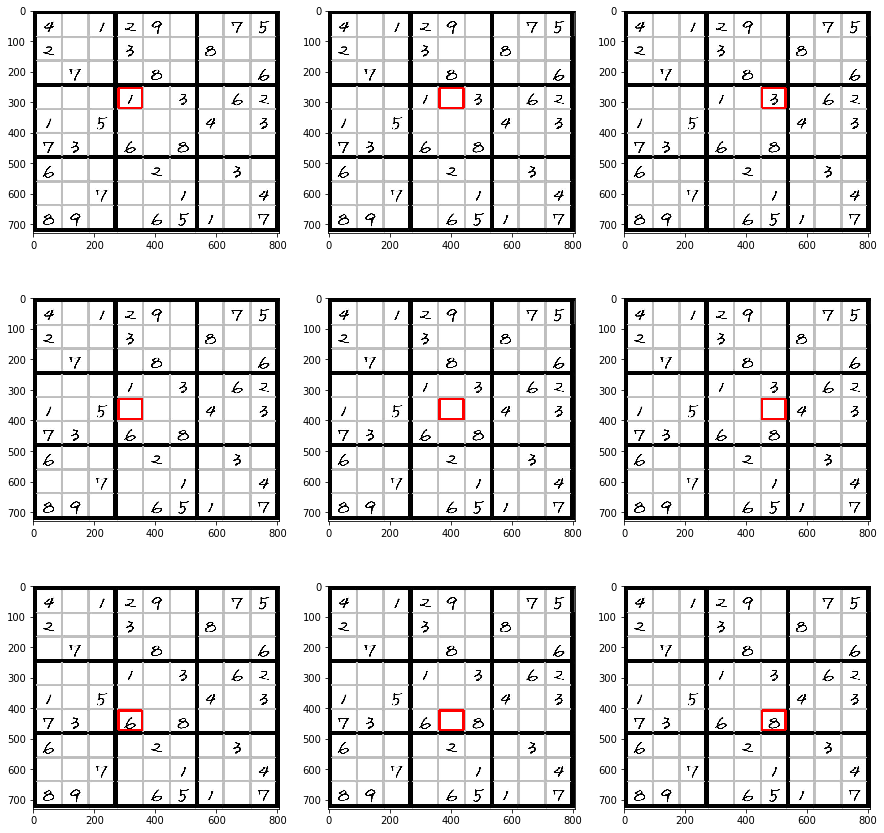

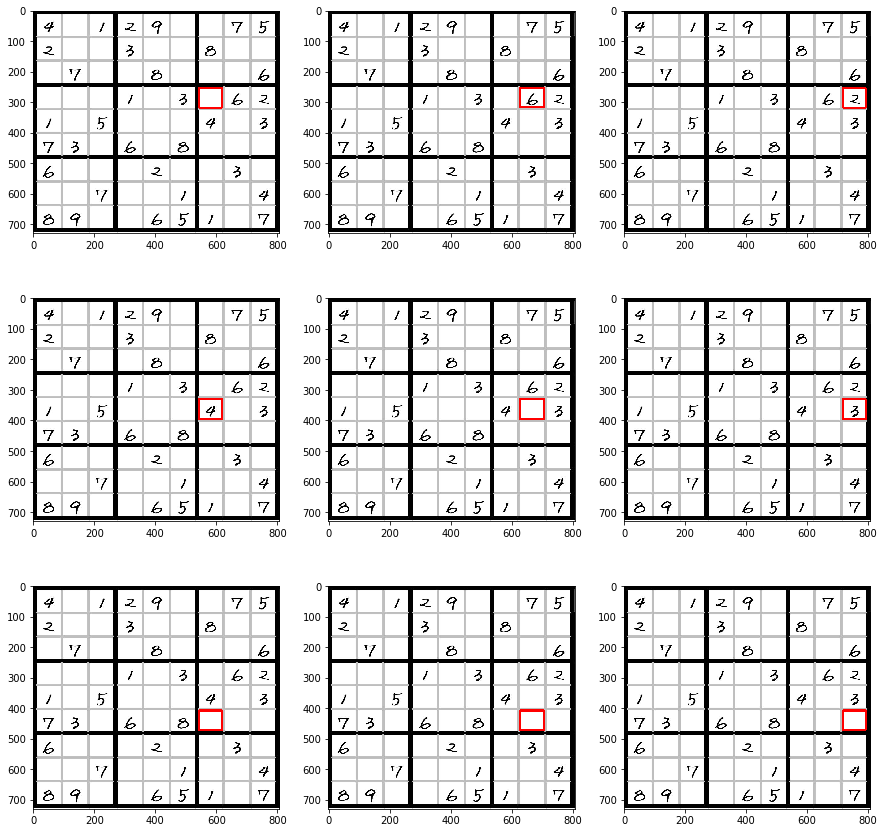

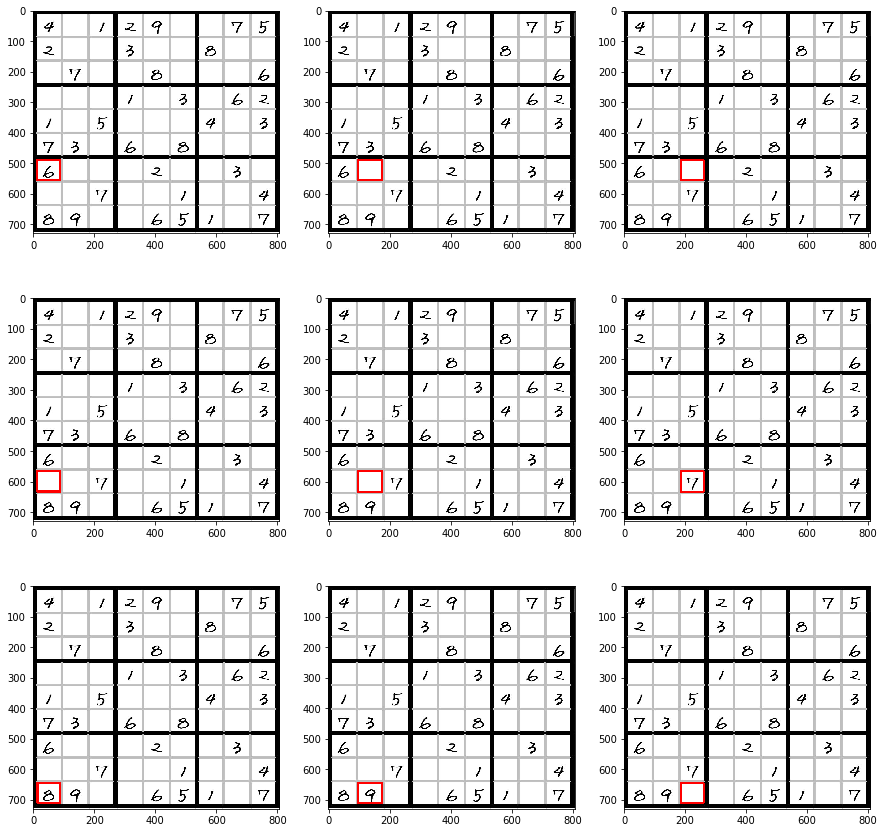

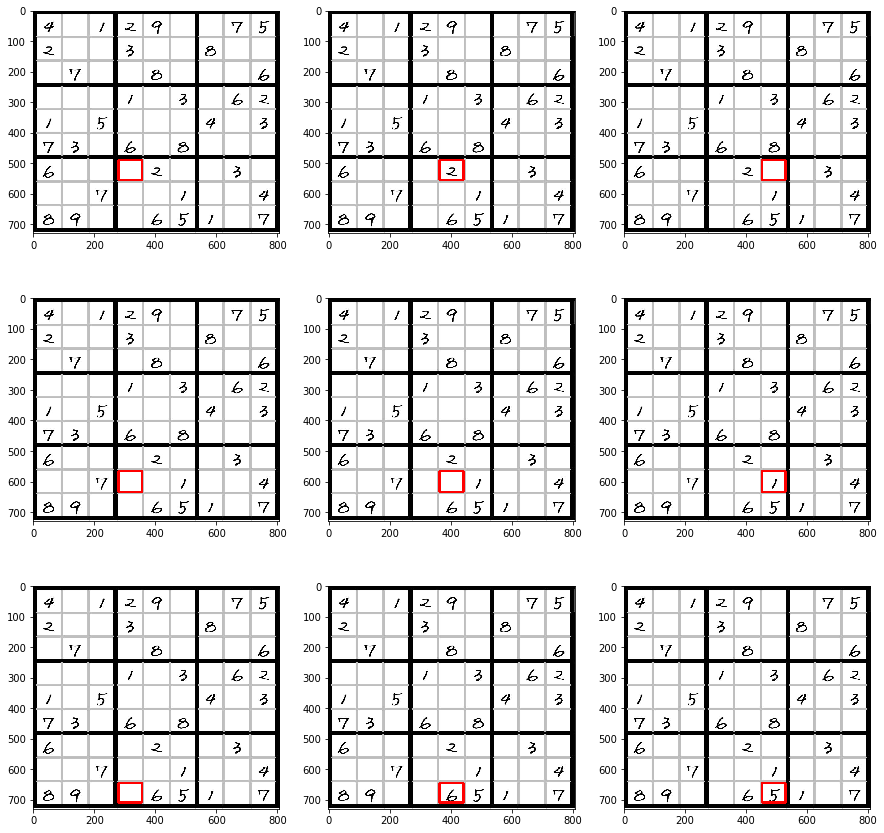

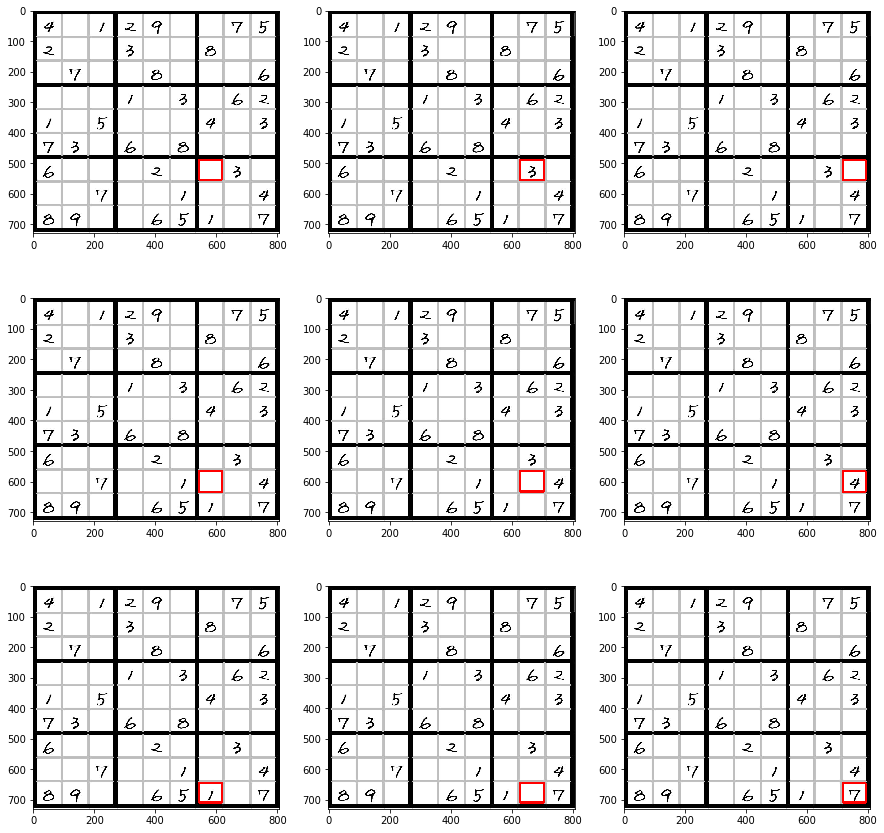

In [465]:
# Iterate on each 3*3 blob to get each 1*1 unit-blob
unit_blobs = []
# erode_img = cv2.erode(dil_img, np.array([[0,1,0],[1,1,1],[0,1,0]], dtype = np.uint8))

for (tl_x, tl_y, br_x, br_y) in sorted_blobs:
    
    sub_img = 255 - np.zeros(img.shape)
    sub_img[tl_y:br_y, tl_x:br_x] = img[tl_y: br_y, tl_x:br_x]
    
    # Pad image
    sub_img[tl_y-5:br_y+5, tl_x-5:br_x+5] = np.pad(sub_img[tl_y:br_y, tl_x:br_x], pad_width = 5, mode = 'constant', constant_values = 0)
    
    # Blur image
    sub_blur_img = cv2.GaussianBlur(sub_img, (5,5), 0)
    
    # Thresholding image
    _, sub_th_img = cv2.threshold(sub_blur_img.astype(np.uint8), 230, 255, cv2.THRESH_BINARY)
    
    # The same as previous operations, get contours, sorting contours to get each unit-blob.
    # Contours finding
    _, sub_contours, _ = cv2.findContours(sub_th_img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort according to contour area
    sorted_sub_contours = sorted(sub_contours, key = lambda x: cv2.contourArea(x), reverse = True)
    
    # Get the first 11 contours by the descending order of contour area.
    # The biggest one is the outline
    # The second to tenth is the outline for each 3*3 sub-soduku
    sub_blobs = []
    for i in range(2,11):
        
        # Approximate contour with lines
        perimeter = cv2.arcLength(sorted_sub_contours[i], True)
        epsilon = 0.1 * cv2.arcLength(sorted_sub_contours[i],True)
        approx = cv2.approxPolyDP(sorted_sub_contours[i], epsilon, True)
        [tl_x, tl_y] = approx[0][0]
        [br_x, br_y] = approx[2][0]
        
        # Store blobs in list
        sub_blobs.append((tl_x, tl_y, br_x, br_y))
    
    # Sort blobs by the location of blob in the image
    # Calculate the center of each blob and sort the list in ascending order of center (x,y)
    sorted_sub_blobs = blob_sorting(sub_blobs)
    
    # Store unit images to unit_blobs list in order
    unit_imgs = []
    plt.figure(figsize = (15,15))
    i = 1
    for (tl_x, tl_y, br_x, br_y) in sorted_sub_blobs:
        
        unit_imgs.append(img[tl_y:br_y,tl_x:br_x])

        sorted_sub_blob_img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), (tl_x, tl_y), (br_x, br_y), color = (255, 0, 0), thickness = 5)
        plt.subplot(3, 3, i)
        plt.imshow(sorted_sub_blob_img)
        i += 1
    
    unit_blobs.append(unit_imgs)

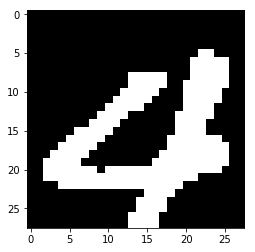

0


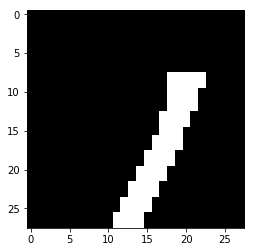

7


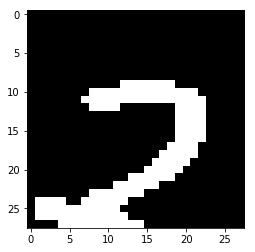

7


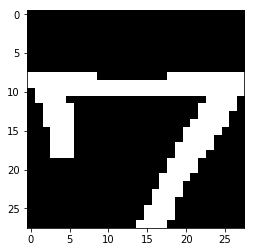

7


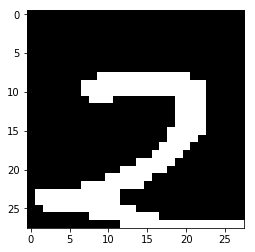

7


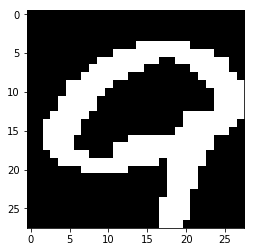

9


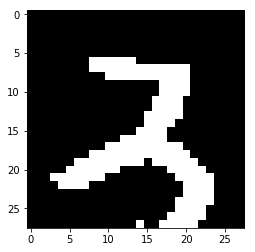

2


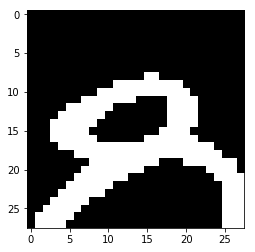

2


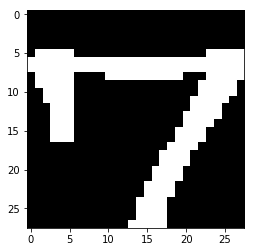

7


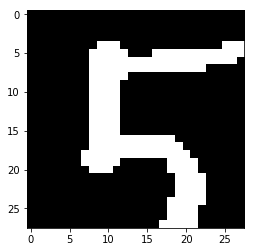

5


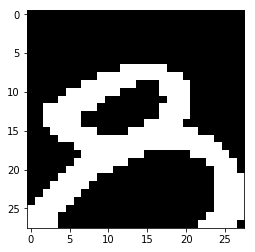

2


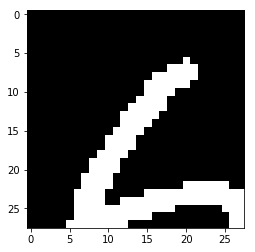

1


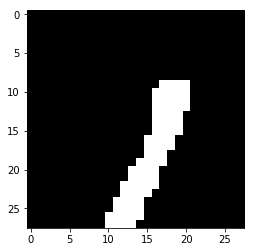

7


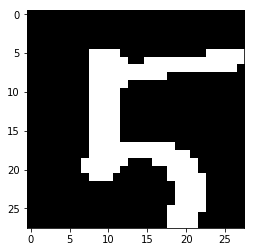

5


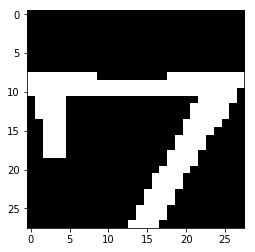

7


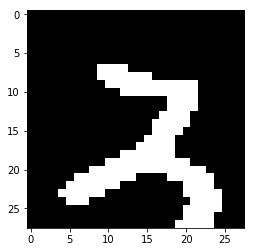

2


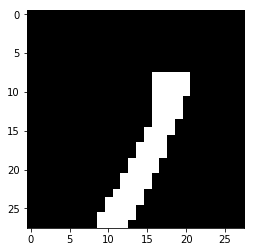

7


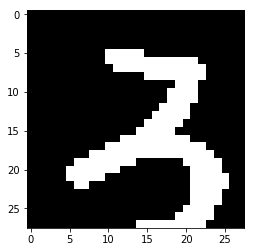

2


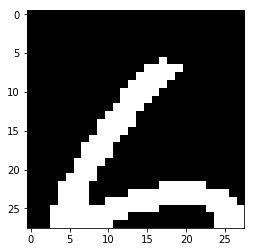

2


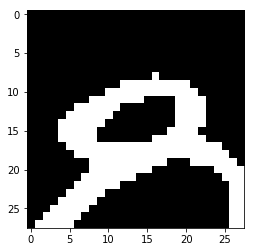

2


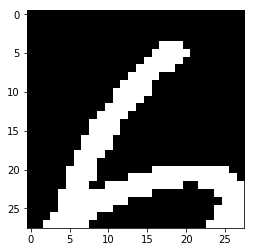

2


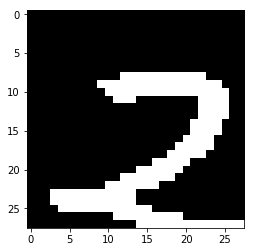

7


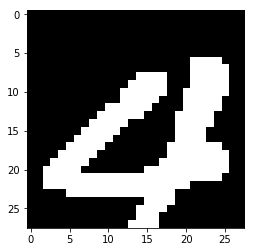

0


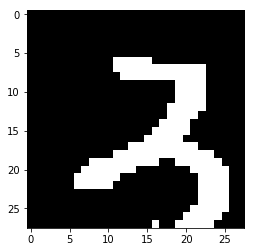

2


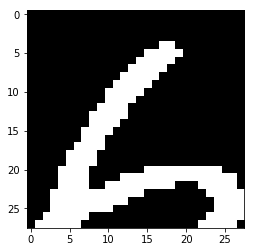

2


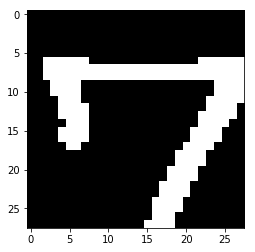

7


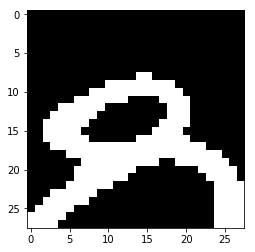

2


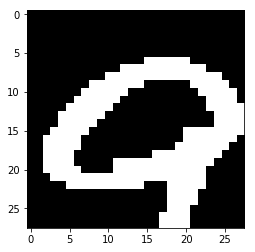

0


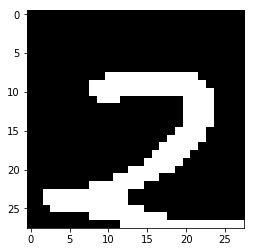

7


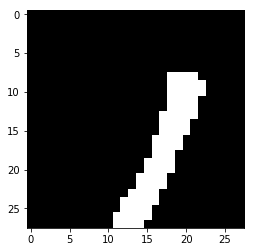

7


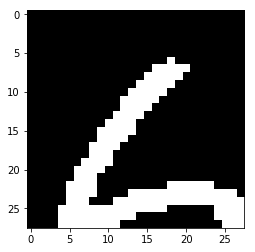

2


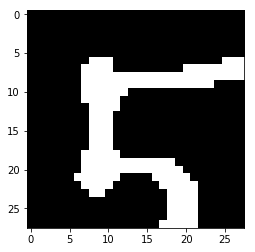

5


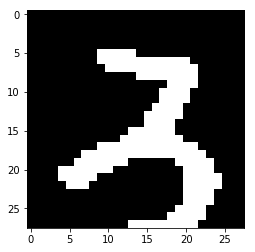

2


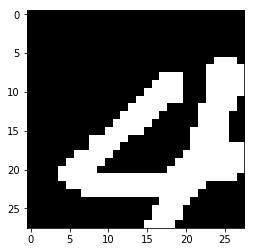

2


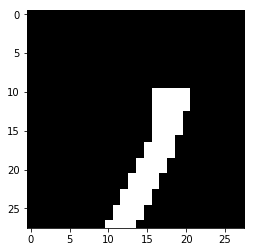

7


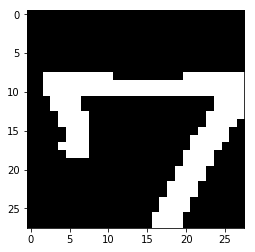

7


In [466]:
# Iterate on the unit_blobs list, each element in the unit_blobs stores a number or empty
# Use scikit-learn MNIST model to recognize each digit
digits = np.zeros([9,9])

for blob in range(len(unit_blobs)):
    for unit in range(len(unit_blobs[0])):        
        
        # Resize image to (28,28) to fit the size of MNIST model input
        row_half, col_half = int(unit_blobs[blob][unit].shape[0]/2), int(unit_blobs[blob][unit].shape[1]/2)
        digit_img = cv2.resize(unit_blobs[blob][unit][row_half-18:row_half+18, col_half-18:col_half+18], (28,28))      
        
        # Check center of image
        if (digit_img[6:18, 6:18] < 255).sum() > 20 and np.count_nonzero(digit_img) != 0:
            _, digit_img = cv2.threshold(digit_img, 127, 255, cv2.THRESH_BINARY)
            input_digit_img = np.reshape(cv2.bitwise_not(digit_img), (-1, 28, 28, 1))
            plt.figure()
            plt.imshow(cv2.bitwise_not(digit_img), cmap = 'gray')
            plt.show()
#             continue
            predicted_digit = sess.run(tf.argmax(tf.nn.softmax(logits), 1), feed_dict = {X: input_digit_img, is_train: False})
            print (predicted_digit[0])